# Purpose


**2023-04-17**:<br>
<br> In this notebook we'll try an end-to-end process to get ANN for a single campaign

- Pull data:
    - User Time on Subreddit (save to local now, GCS in prod)
    - Get subreddit-level embeddings (save to local, GCS in prod)
- Reshape to get user-embeddings
    - For each ToSub file, get weighted embeddings for a user
        - Save user-level (weighted) embeddings to file
- Calculate ANN distance to input subreddit(s)
    - Create an index with ANNOY: per COUNTRY + subreddit
        - This way we ensure a minimum # of users per country
    - Load subreddit-embedding file
    - For each input target subreddit, get the ANN users
        - Try nearest 3 million users
    - Save raw ANN file
- Save file ready for model training

TODO later / out of scope
- Split training file into k-fold validation or train/test
- Train base models (do it a separate notebook)
- [later/tbd] Reshape ANN table & upload to BQ table
    - Reshape ANN file for BigQuery format
    - Upload ANN file to BQ for table creation




# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import gc
import logging
from logging import info
import os
from pathlib import Path
import json

import polars as pl
import numpy as np
import pandas as pd
import plotly
import seaborn as sns

from tqdm.auto import tqdm
import dask
import mlflow

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
from google.cloud import bigquery
from subclu.pn_models import get_data


client = bigquery.Client()

print_lib_versions([bigquery, np, pd, pl, plotly, mlflow, subclu])

python		v 3.7.10
===
google.cloud.bigquery	v: 2.13.1
numpy		v: 1.19.5
pandas		v: 1.2.4
polars		v: 0.17.1
plotly		v: 5.11.0
mlflow		v: 1.16.0
subclu		v: 0.6.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Define local path for this model outputs

In [14]:
manual_model_timestamp = datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')
path_this_model = get_project_subfolder(
    f"data/models/pn_model/pn_manual_test_{manual_model_timestamp}"
)
Path.mkdir(path_this_model, parents=True, exist_ok=True)
print(path_this_model)

/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-17_161043


# Define key inputs
Use these throughout the process to filter/target specific subreddits, geos, & users

In [23]:
l_target_subreddits = ['de']

# We would want to add an automated way to pick these ANN subs, but look them up manually for now
l_target_ann_subreddits = ['fragreddit', 'ich_iel']

l_target_geos = ['DE']

# Get subreddit-level embeddings

For this part BigQuery + pandas is fast enough.

Model partition (`pt`) is generally trained on a Tuesday.

ETA: 
- ~ 20 seconds to pull the data
- ~15 seconds to conver to wide format

Example:
```bash
pt
0	2022-11-22
1	2022-11-29
2	2022-12-06
3	2022-12-13
4	2022-12-20
5	2022-12-27
```

In [17]:
%%time
%%bigquery df_sub_emb_raw --project data-science-prod-218515 

-- We do the un-nesting in pandas because with UNNESTING in SQL ORDER IS NOT GUARANTEED!
SELECT
  subreddit_id
  , subreddit_name
  , ARRAY_CONCAT(embedding) AS embedding

FROM `data-prod-165221.ml_content.subreddit_embeddings_ft2`
WHERE DATE(pt) = '2022-11-29'


Query is running:   0%|          | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|          | 0/2 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|██████████| 2/2 [00:00<00:00, 651.14query/s]                         

Downloading: 100%|██████████| 236115/236115 [00:02<00:00, 82239.13rows/s] 


CPU times: user 698 ms, sys: 413 ms, total: 1.11 s
Wall time: 13.8 s


In [19]:
df_sub_emb_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236115 entries, 0 to 236114
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   subreddit_id    236115 non-null  object
 1   subreddit_name  236115 non-null  object
 2   embedding       236115 non-null  object
dtypes: object(3)
memory usage: 5.4+ MB


## Transform - sub embeddings to wide

In [20]:
%%time

n_emb_cols = df_sub_emb_raw['embedding'].iloc[0].shape[0]
assert np.alltrue(n_emb_cols == df_sub_emb_raw['embedding'].str.len())


embedding_col_prefix = 'embedding_'
l_emb_cols = [f"{embedding_col_prefix}{i:03,.0f}" for i in range(n_emb_cols)]
info(f"{len(l_emb_cols):,.0f} <- Embedding columns")

info(f"Converting to wide format...")
df_sub_emb_pd = pd.DataFrame(
    list(df_sub_emb_raw['embedding']),
    columns=l_emb_cols,
    index=pd.MultiIndex.from_frame(df_sub_emb_raw[['subreddit_id', 'subreddit_name']]),
).reset_index()

r_, c_ = df_sub_emb_pd.shape 
info(f"{r_:,.0f}, {c_:,.0f} <- embeddings WIDE shape")

info(f"Save wide embeddings to parquet")
df_sub_emb_pd.to_parquet(
    path_this_model / f"df_subreddit_embeddings_wide-{r_}_{c_}.parquet",
    index=False,
)

info(f"Converting to polars df...")
df_sub_emb = pl.from_pandas(df_sub_emb_pd)

info(f"Subreddit embeddings pre-processing done")
# delete the pandas df to free up memory
del df_sub_emb_pd
gc.collect()

16:22:23 | INFO | "100"
16:22:23 | INFO | "Converting to wide format..."
16:22:36 | INFO | "236,115, 102 <- embeddings WIDE shape"
16:22:36 | INFO | "Save wide embeddings to parquet"
16:22:38 | INFO | "Converting to polars df..."
16:22:38 | INFO | "Subreddit embeddings pre-processing done"


CPU times: user 13.9 s, sys: 1.84 s, total: 15.8 s
Wall time: 16.1 s


0

In [21]:
df_sub_emb[:4, :15]

subreddit_id,subreddit_name,embedding_000,embedding_001,embedding_002,embedding_003,embedding_004,embedding_005,embedding_006,embedding_007,embedding_008,embedding_009,embedding_010,embedding_011,embedding_012
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""t5_70sqiq""","""00000009999""",0.203673,0.41239,0.293499,0.219038,0.067274,-0.074245,-0.515791,0.701312,0.733369,-0.565209,-0.096566,0.40944,0.082867
"""t5_6z8n1c""","""0010110zion""",0.020021,0.08691,0.152663,-0.412483,0.074653,-0.005074,-0.308147,0.06658,0.161424,-0.091454,-0.170465,-0.028941,-0.293559
"""t5_71a1re""","""002timmynfts""",-0.066831,-0.024192,0.682037,-0.081226,0.046117,0.285765,-0.226684,0.041478,0.301822,-0.476785,0.068413,0.070616,0.234421
"""t5_6xknxn""","""007desinsfw""",0.028375,-0.157933,0.722232,-0.22489,-0.123628,0.128553,0.227722,0.294614,-0.090551,-0.643633,0.347671,0.175447,0.225121


In [22]:
df_sub_emb[4:6, :15]

subreddit_id,subreddit_name,embedding_000,embedding_001,embedding_002,embedding_003,embedding_004,embedding_005,embedding_006,embedding_007,embedding_008,embedding_009,embedding_010,embedding_011,embedding_012
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""t5_3oco2x""","""007nightfire""",-0.04789,0.518611,0.222843,-0.142906,0.122165,0.196806,-0.053357,-0.257993,0.720489,-0.112393,-0.089884,0.070488,-0.129584
"""t5_6xv2qd""","""00_x""",0.047263,-0.227378,0.631552,-0.263744,-0.619626,0.251459,-0.253667,0.059874,0.414293,-1.12446,0.003658,0.32285,0.144135


In [ ]:
# Select target users
Create a table for these target users

In [25]:
%%time
%%bigquery _ --project data-science-prod-218515 

-- Get test users for end-to-end embeddings
-- TODO(djb): Filters
--   - remove users who only viewed one subreddit
--   - keep users with an iOS or Android event
DECLARE PT_DT DATE DEFAULT "2022-12-01";
DECLARE PT_WINDOW_START DATE DEFAULT PT_DT - 13;

DECLARE TARGET_COUNTRIES DEFAULT [
    "DE", "AT", "CH"
];


CREATE OR REPLACE TABLE `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_20230417` AS (
SELECT
    PT_DT AS pt
    , PT_WINDOW_START AS pt_window_start
    , v.subreddit_id
    , v.subreddit_name
    , v.user_id
    , g.geo_country_code

    , COUNT(DISTINCT post_id) AS view_and_consume_unique_count
    , COUNT(DISTINCT(IF(v.action='consume', post_id, NULL))) AS consume_unique_count
    , SUM(IF(v.action='view', 1, 0)) AS view_count
    , SUM(IF(v.action='consume', 1, 0)) AS consume_count
    , SUM(IF(v.action='consume' AND app_name='ios', 1, 0)) AS consume_ios_count
    , SUM(IF(v.action='consume' AND app_name='android', 1, 0)) AS consume_android_count

FROM (
    SELECT
        user_id
        , geo_country_code
    FROM `data-prod-165221.channels.user_geo_6mo_lookback`
    WHERE
        DATE(pt) = PT_DT
        AND geo_country_code IN UNNEST(TARGET_COUNTRIES)
) AS g
    INNER JOIN `data-prod-165221.fact_tables.post_consume_post_detail_view_events` AS v
        on g.user_id = v.user_id

    -- TODO(djb): join to get only users who have at least 1 ios or android event in ANY sub
WHERE DATE(v.pt) BETWEEN PT_WINDOW_START AND PT_DT
    AND v.user_id IS NOT NULL
    AND v.subreddit_name IN (
        -- 1st sub is a target from a campaign & following ones are most similar based on ft2 embeddings:
        'de', 'fragreddit', 'ich_iel'
    )
    AND action IN ('consume', 'view')
GROUP BY 1,2,3,4,5,6
);


Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 788.40query/s] 

CPU times: user 971 ms, sys: 99.8 ms, total: 1.07 s
Wall time: 1min 31s


In [26]:
%%time
%%bigquery df_target_user_counts --project data-science-prod-218515 

SELECT
    COUNT(*) AS row_count
    , COUNT(DISTINCT user_id) AS user_id_count
FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_20230417`
;


Query is running:   0%|          | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|          | 0/5 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|██████████| 5/5 [00:00<00:00, 1418.53query/s]                        

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.18s/rows]

CPU times: user 52.2 ms, sys: 11.9 ms, total: 64.1 ms
Wall time: 4.41 s


In [27]:
df_target_user_counts

,row_count,user_id_count
0,3601830,2041130


In [36]:
del df_target_user_counts

## Get Time-on-Subreddit (ToS) for target user IDs

We'll use these to create weighted embeddings.

I'm caching the `selected users` in a table so that it's easier/faster to re-use while testing.

The time-on-subreddit feature is already in gazette features so we don't need to waste time computing them.

Key tables:
- Select users:
    - `data-prod-165221.fact_tables.post_consume_post_detail_view_events` 
- Get ToS:
    - `data-prod-165221.user_feature_platform.time_on_subreddit_pct_time_over_30_day_v1`
    
 ---


In [28]:
%%time
%%bigquery _ --project data-science-prod-218515 

-- Pull the user IDs + time on subreddit
--   Using temp function because it's much faster to expand ToS in BQ than in python
--   But we need to write the data to a table because the response can be huge (billions of rows)
DECLARE PT_TOS DATE DEFAULT "2022-12-01";

CREATE TEMP FUNCTION
tosParser(tosString STRING)
RETURNS STRUCT<
    subreddit_id STRING,
    tos_30_pct FLOAT64
>
LANGUAGE js AS """
   arr = tosString.split(':');
   this.subreddit_id = arr[0].slice(1, -1);
   this.tos_30_pct = parseFloat(arr[1]);
   return this;
"""
;


CREATE OR REPLACE TABLE `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_tos_30_pct_20230417`
CLUSTER BY user_id
AS (
WITH tos_filtered AS (
SELECT
    u.user_id
    , t.feature_value
FROM `data-prod-165221.user_feature_platform.time_on_subreddit_pct_time_over_30_day_v1` AS t
    INNER JOIN(
        SELECT
            DISTINCT user_id
        FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_20230417`
        -- LIMIT 10
    ) AS u
        ON u.user_id = t.entity_id
WHERE DATE(t.pt) = PT_TOS
)
, tos_exploded AS (
SELECT
    user_id
    , tosParser(feature_array_exploded).*
FROM(
    SELECT user_id, feature_array_exploded
    FROM (
        SELECT user_id, SPLIT(RTRIM(LTRIM(feature_value, '{'), '}')) AS feature_array FROM tos_filtered
    ), UNNEST(feature_array) AS feature_array_exploded
)
)


SELECT *
FROM tos_exploded

WHERE
    -- Limit smallest sub b/c at some point it's a waste to try to aggregate such small embeddings
    tos_30_pct >= 0.0001
);



Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 740.26query/s] 

CPU times: user 118 ms, sys: 34.2 ms, total: 152 ms
Wall time: 14.2 s


In [31]:
%%time
%%bigquery df_tos_counts --project data-science-prod-218515 
-- Count checks
SELECT
    COUNT(*) AS row_count
    , COUNT(DISTINCT user_id) AS user_id_count
FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_tos_30_pct_20230417`
;



Query is running:   0%|          | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|          | 0/4 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|██████████| 4/4 [00:00<00:00, 1271.10query/s]                        

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.24s/rows]

CPU times: user 45.8 ms, sys: 9.96 ms, total: 55.7 ms
Wall time: 4.04 s


In [32]:
df_tos_counts

,row_count,user_id_count
0,83382651,1844353


In [35]:
del df_tos_counts


### Load data from GCS because loading straight from BQ takes too long (stopped after waiting for 30 minutes). 

```bash
# Copy: the -n flag only copies "NEW" files
# !gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m cp -r -n $remote_gs_path $local_f

# rsync can be nicer because with `-n` you get a preview (dry run) before running a command
# !gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r -n $gcs_tos $local_path_tos
```

Note that it's better to run this command from the CLI because it can crash jupyter (fast log info 

In [34]:
%%time
%%bigquery _ --project data-science-prod-218515 

-- Export data to GCS because querying such a huge table takes forever and a half
EXPORT DATA OPTIONS(
    uri='gs://i18n-subreddit-clustering/pn_model/runs/de_only_20230417/user_tos_30_pct/*.parquet',
    format='PARQUET',
    overwrite=true
) AS
SELECT *
FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_tos_30_pct_20230417`
;


Query is running:   0%|          | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Output and status COMPLETE : 0.00s:   0%|          | 0/1 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 415.28query/s]                          

CPU times: user 58.6 ms, sys: 1.33 ms, total: 60 ms
Wall time: 3.63 s


Note:
- The `-r` flag creates a "dry-run" (only tells you what will happen)
- for final CLI command remove this flat (`-r`)

In [43]:
bucket_name_ = 'i18n-subreddit-clustering'
gcs_tos = f"gs://{bucket_name_}/pn_model/runs/de_only_20230417/user_tos_30_pct/"

path_local_cache = Path(f"/home/jupyter/subreddit_clustering_i18n/data/local_cache/{bucket_name_}/")
local_path_tos = (
    path_local_cache / 
    gcs_tos.split(f"{bucket_name_}/")[1]
)
Path.mkdir(local_path_tos, exist_ok=True, parents=True)


print(f"GCS URI:\n  {gcs_tos}\nLocal path:\n  {local_path_tos}")

print(f"\nCLI command:")
!echo gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r -n $gcs_tos $local_path_tos

GCS URI:
  gs://i18n-subreddit-clustering/pn_model/runs/de_only_20230417/user_tos_30_pct/
Local path:
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/de_only_20230417/user_tos_30_pct

CLI command:
gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r -n gs://i18n-subreddit-clustering/pn_model/runs/de_only_20230417/user_tos_30_pct/ /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/de_only_20230417/user_tos_30_pct


In [45]:
%%time

df_user_tos = pl.read_parquet(f"{local_path_tos}/*.parquet")

CPU times: user 10.2 s, sys: 3.95 s, total: 14.1 s
Wall time: 2.26 s


In [46]:
df_user_tos.shape

(83382651, 3)

In [47]:
%%time
df_user_tos.sample(n=int(1e6)).describe()

CPU times: user 1.18 s, sys: 582 ms, total: 1.76 s
Wall time: 969 ms


describe,user_id,subreddit_id,tos_30_pct
str,str,str,f64
"""count""","""1000000""","""1000000""",1e6
"""null_count""","""0""","""0""",0.0
"""mean""",null,null,0.021946
"""std""",null,null,0.094023
"""min""","""t2_100078""","""t5_100eoi""",0.0001
"""max""","""t2_zzz70""","""t5_zzszh""",1.0
"""median""",null,null,0.00126


In [48]:
df_user_tos.head()

user_id,subreddit_id,tos_30_pct
str,str,f64
"""t2_10jcae""","""t5_33x33""",0.008
"""t2_10ojl9oz""","""t5_2zzfr""",0.01521
"""t2_10ovevbv""","""t5_2xp2o""",0.0008
"""t2_10nfxs""","""t5_12h1g7""",0.00059
"""t2_10nfxs""","""t5_7dqr4z""",0.00015


# Other Transforms 

We don't need these transforms for ANN, but will use it for modeling step
- Count of subreddits per user for ToS

Other data:
- Subscribed to target subreddit
- Age of account
- Activity in L14 days
- etc...



---


# Compute user-level weighted embedding

now that we have the long df, let's compute the user-level weighted embedding (multiply weights x embedding & groupby user-id)

## Run on all users

Batches of 150-million user<>subreddit weighted embeddings was too much memory (over 1.2 TB). So the kernel gets killed/dies.

Instead, try to run in batches of
- 80 to 100 million ToS rows

---

Example ETAs:

```bash
# 800k users | 130 million ToS rows
07:08:08 | INFO | "Append subreddit embeddings to user ToS"
07:08:13 | INFO | "Compute weighted avg embedding for user-level"
07:09:49 | INFO | "Compute AGGREGATED user-level embedding..."
(130601209, 100)
(856211, 101)
CPU times: user 18min 9s, sys: 8min 21s, total: 26min 31s
Wall time: 4min 52s


# 9.8 million users |  764.5 million ToS rows
10:49:14 | INFO | "Compute weighted ToS embeddings..."
10:58:43 | INFO | "(764565252, 102) <- df.shape ToS with weighted embedddings"
10:58:43 | INFO | "Delete temp df to free up memory"
10:58:43 | INFO | "Compute AGGREGATED user-level embedding..."
10:59:50 | INFO | "(9874962, 101) <- df.shape User weighted embedddings"
(764565252, 102)
(9874962, 101)
CPU times: user 2h 53min 2s, sys: 44min 23s, total: 3h 37min 25s
Wall time: 23min 30s

```

17:00:04 | INFO | "83,382,651 <- Data Size"
17:00:04 | INFO | "80,000,000 <- Batch Size"
17:00:04 | INFO | "0,000,002 <- Chunks"
17:00:04 | INFO | "Append subreddit embeddings to user ToS"
17:00:12 | INFO | "(70649280, 103) <- df.shape ToS with raw embeddings (no nulls)"
17:00:13 | INFO | "Create DAG for weighted avg embedding per user+subreddit"


  0%|          | 0/2 [00:00<?, ?it/s]

17:01:06 | INFO | "Dask visualize DAG"


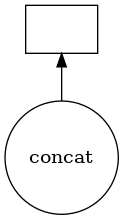

17:01:08 | INFO | "Compute weighted ToS embeddings..."
17:01:29 | INFO | "(70649280, 102) <- df.shape ToS with weighted embedddings"
17:01:29 | INFO | "Delete temp df to free up memory"
17:01:29 | INFO | "Compute AGGREGATED user-level embedding..."
17:01:35 | INFO | "(1831171, 101) <- df.shape User weighted embedddings"


(1831171, 101)
CPU times: user 13min 44s, sys: 4min 33s, total: 18min 18s
Wall time: 1min 30s


In [49]:
%%time

# when computing on full data set, we need to batch b/c the computer will run out of RAM if/when converting parquet to numpy
n_sample = None  # None  # None  int(10e6)

if n_sample is None:
    df_user_tos_proc_ = df_user_tos
else:
    df_user_tos_proc_ = df_user_tos.sample(n=n_sample, seed=42)
n_size = len(df_user_tos_proc_)

batch_size = int(80e6)  # int(110e6), 9e6 = 9Million
n_chunks = 1 + n_size // batch_size
iter_chunks = range(n_chunks)

info(f"{n_size:09,.0f} <- Data Size")
info(f"{batch_size:09,.0f} <- Batch Size")
info(f"{n_chunks:09,.0f} <- Chunks")


info(f"Append subreddit embeddings to user ToS")
df_user_emb_tmp = (
    df_user_tos_proc_
    .join(
        df_sub_emb.drop('subreddit_name'),
        how='left',
        on=['subreddit_id']
    )
    # Drop or replace nulls as early as possible
    .drop_nulls()
)
info(f"{df_user_emb_tmp.shape} <- df.shape ToS with raw embeddings (no nulls)")
gc.collect()

info(f"Create DAG for weighted avg embedding per user+subreddit")
# Use dask.delayed() to compute these in parallel & prevent some OOM errors
l_dfs_tos_wt = list()
for i in tqdm(iter_chunks, mininterval=0.1, ascii=True):
    l_dfs_tos_wt.append(
        df_user_emb_tmp[['user_id', 'subreddit_id']][:batch_size]
        .with_columns(
            pl.DataFrame(
                data=(
                    np.multiply(
                        df_user_emb_tmp['tos_30_pct'][:batch_size].to_numpy(),
                        df_user_emb_tmp[l_emb_cols][:batch_size].to_numpy().T
                    ).T
                ),
                schema=l_emb_cols,
            )
        )
    )
    # delete processed rows to save space
    df_user_emb_tmp = df_user_emb_tmp[batch_size:]
    gc.collect()

df_user_emb_tmp_wt_del = dask.delayed(pl.concat)(
    l_dfs_tos_wt, how='vertical', parallel=True
)
info(f"Dask visualize DAG")
display(df_user_emb_tmp_wt_del.visualize(
    f"dask_DAG-{n_size}_data-{batch_size}_batch_size-{n_chunks}_chunks.png"
))
gc.collect()
info(f"Compute weighted ToS embeddings...")
df_user_emb_tmp_wt = df_user_emb_tmp_wt_del.compute()
info(f"{df_user_emb_tmp_wt.shape} <- df.shape ToS with weighted embedddings")

info(f"Delete temp df to free up memory")
del df_user_emb_tmp
gc.collect()

info(f"Compute AGGREGATED user-level embedding...")
df_user_emb = (
    df_user_emb_tmp_wt
    .groupby(
        ['user_id']
    )
    .agg(
        [
            pl.col(l_emb_cols).mean()
        ]
    )
)
info(f"{df_user_emb.shape} <- df.shape User weighted embedddings")
gc.collect()
print(df_user_emb.shape)

In [51]:
df_user_emb[:4, :15]

user_id,embedding_000,embedding_001,embedding_002,embedding_003,embedding_004,embedding_005,embedding_006,embedding_007,embedding_008,embedding_009,embedding_010,embedding_011,embedding_012,embedding_013
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""t2_3dztlwp1""",-0.003785,0.003161,0.000537,-0.001168,-0.002078,0.000971,-0.002561,0.000304,0.005292,0.001673,0.000477,0.004041,-0.000734,-0.001473
"""t2_27a2p6nm""",-0.000677,0.001204,0.001093,-0.001587,0.000388,0.001258,-0.001489,-0.000857,0.003769,0.000087,-0.001806,0.00205,0.002429,-0.001141
"""t2_e63nvy24""",-0.02928,0.065853,0.076953,0.003259,-0.289421,-0.114375,-0.210511,0.01387,0.29104,-0.068335,-0.178308,-0.097683,-0.060427,-0.172378
"""t2_7bkn2dls""",-0.000502,0.014535,-0.005488,0.006118,-0.010488,-0.00213,-0.007979,0.007133,0.007597,0.014688,0.013892,0.007289,0.006347,-0.008107


In [52]:
%%time

r_, c_ = df_user_emb.shape

f_user_embedding_name = (
    path_this_model / 
    f"df_user_embedding-{datetime.utcnow().strftime('%Y-%m-%d_%H%M')}"
    f"-{r_}_by_{c_}.parquet"
)
print(f_user_embedding_name)

df_user_emb.write_parquet(
    f_user_embedding_name
)

del r_, c_

/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-17_161043/df_user_embedding-2023-04-17_1705-1831171_by_101.parquet
CPU times: user 15.5 s, sys: 1.08 s, total: 16.6 s
Wall time: 17.6 s


In [ ]:
LEGACY

In [35]:
%%time
n_users_sample = df_user_tos['user_id'].n_unique()
info(f"{n_users_sample:,.0f} Users in run")

11:02:42 | INFO | "9,889,351 Users in run"


CPU times: user 26.5 s, sys: 5.79 s, total: 32.3 s
Wall time: 32 s


In [36]:
n_mins_sample = 24 + 3
n_users_target = 60e6

seq_proc_time = n_mins_sample * (n_users_target / n_users_sample) / 60
info(f"{seq_proc_time:,.2f}  Hours to get user-embeddings SEQUENTIALLY")

14:55:51 | INFO | "2.73  Hours to get user-embeddings SEQUENTIALLY"


# Other tests

In [ ]:
# Delaying the multiplication doesn't help with the OOM error
l_dfs_tos_wt = list()
for i in tqdm(iter_chunks, mininterval=0.1, ascii=True):
    l_dfs_tos_wt.append(
        dask.delayed(pl.select)(
            df_user_emb_tmp[['user_id', 'subreddit_id']]
            [i * batch_size:(i + 1) * batch_size]
        )
        .with_columns(
            dask.delayed(pl.DataFrame)(
                data=(
                    dask.delayed(np.multiply)(
                        dask.delayed(df_user_emb_tmp['tos_30_pct'][i * batch_size:(i + 1) * batch_size].to_numpy()),
                        dask.delayed(df_user_emb_tmp[l_emb_cols][i * batch_size:(i + 1) * batch_size].to_numpy().T)
                    ).T
                ),
                schema=l_emb_cols,
            )
        )
    )


## compare creating weighted matrix in pandas v. polars
polars is faster. but part of it might be that I'm creating an index and then resetting it...

in any case, sticking to polars as much as possible is probably better for consistency and performance

In [ ]:
BREAK

In [149]:
%%time
info(f"Append subreddit embeddings to user ToS")
df_user_emb_tmp_test = (
    df_user_tos
    .join(
        pl.DataFrame(sample_users),
        how='inner',
        on=['user_id'],
    )
    .join(
        df_sub_emb.drop('subreddit_name'),
        how='left',
        on=['subreddit_id']
    )
    # Drop or replace nulls as early as possible
    .drop_nulls()
)
info(f"{df_user_emb_tmp_test.shape} <- df.shape ToS with raw embeddings (no nulls)")

06:32:34 | INFO | "Append subreddit embeddings to user ToS"
06:32:36 | INFO | "(67217, 103) <- df.shape ToS with raw embeddings (no nulls)"


CPU times: user 2min 18s, sys: 12.1 s, total: 2min 30s
Wall time: 2.01 s


In [79]:
%%time

_pl = (
    df_user_emb_tmp_test[['user_id', 'subreddit_id']]
    .with_columns(
        pl.DataFrame(
            data=((df_user_emb_tmp_test['tos_30_pct'].to_numpy()) * df_user_emb_tmp_test[l_emb_cols].to_numpy().T).T,
            schema=l_emb_cols,
        )
    )
)
print(_pl.shape)

(67217, 102)
CPU times: user 337 ms, sys: 248 ms, total: 585 ms
Wall time: 69.3 ms


In [78]:
%%time
_pd = pd.DataFrame(
    ((df_user_emb_tmp_test['tos_30_pct'].to_numpy()) * df_user_emb_tmp_test[l_emb_cols].to_numpy().T).T,
    index=pd.MultiIndex.from_frame(df_user_emb_tmp_test[['user_id', 'subreddit_id']].to_pandas()),
    columns=l_emb_cols,
).reset_index()
print(_pd.shape)

(67217, 102)
CPU times: user 423 ms, sys: 42.5 ms, total: 466 ms
Wall time: 88.7 ms


In [80]:
_pd.equals(_pl.to_pandas())

True

In [82]:
%%timeit

_pl = (
    df_user_emb_tmp_test[['user_id', 'subreddit_id']]
    .with_columns(
        pl.DataFrame(
            data=((df_user_emb_tmp_test['tos_30_pct'].to_numpy()) * df_user_emb_tmp_test[l_emb_cols].to_numpy().T).T,
            schema=l_emb_cols,
        )
    )
)

51.5 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
%%timeit
_pd = pd.DataFrame(
    ((df_user_emb_tmp_test['tos_30_pct'].to_numpy()) * df_user_emb_tmp_test[l_emb_cols].to_numpy().T).T,
    index=pd.MultiIndex.from_frame(df_user_emb_tmp_test[['user_id', 'subreddit_id']].to_pandas()),
    columns=l_emb_cols,
).reset_index()

67.3 ms ± 820 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Lazy calculation for weighted embeddings 
Lazy give us less info in between stages, but it *could* be faster (in theory) because the query optimizer would have more/better info for the whole DAG.

However, NVM for now. I'm using numpy in the middle to get the weighted values, so we need eager execution.

In [140]:
# %%time

# info(f"Append subreddit embeddings to user ToS")
# df_user_emb_tmp_test = (
#     df_user_tos
#     .lazy()
#     .filter(
#         df_user_tos['user_id'].is_in(sample_users)
#     )
#     .join(
#         df_sub_emb.drop('subreddit_name').lazy(),
#         how='left',
#         on=['subreddit_id']
#     )
#     # Drop or replace nulls as early as possible
#     .drop_nulls()
# )
# # Can't get shape of a lazy df
# # info(f"{df_user_emb_tmp_test.shape} <- df.shape ToS with raw embeddings (no nulls)")

# info(f"Compute weighted avg embedding for user-level")
# df_user_emb_tmp_wt_test = (
#     df_user_emb_tmp_test
#     .select(['user_id', 'subreddit_id'])
#     .with_columns(
#         pl.DataFrame(
#             data=((df_user_emb_tmp_test.select(['tos_30_pct']).to_numpy()) * df_user_emb_tmp_test.select([l_emb_cols]).to_numpy().T).T,
#             schema=l_emb_cols,
#         ).lazy()
#     )
# )
# # info(f"{df_user_emb_tmp_wt_test.shape} <- df.shape ToS with weighted embedddings")


# info(f"Compute AGGREGATED user-level embedding...")
# df_user_emb_test = (
#     pl.DataFrame(df_user_emb_tmp_wt_test_pd)
#     .groupby(
#         ['user_id']
#     )
#     .agg(
#         [
#             pl.col(l_emb_cols).mean()
#         ]
#     )
#     .collect()
# )
# info(f"{df_user_emb_test.shape} <- df.shape User weighted embedddings")
# print(df_user_emb_test.shape)

In [30]:
%%time

test_mult = np.multiply(
    df_user_emb_tmp['tos_30_pct'].to_numpy(), df_user_emb_tmp[l_emb_cols].to_numpy().T
).T
test_mult.shape

CPU times: user 11.7 s, sys: 8.84 s, total: 20.5 s
Wall time: 3.17 s


(8982315, 100)

In [38]:
%%time

test_mult_ = dask.delayed(np.multiply)(
    dask.delayed(df_user_emb_tmp['tos_30_pct'].to_numpy()), 
    dask.delayed(df_user_emb_tmp[l_emb_cols].to_numpy().T)
).T
test_mult_.visualize()
test_mult_del_ = test_mult_.compute()

CPU times: user 11.6 s, sys: 8.58 s, total: 20.2 s
Wall time: 3.47 s


In [39]:
test_mult_del_.shape

(8982315, 100)

In [32]:
%%time

np.allclose(
    test_mult,
    df_user_emb_tmp_wt[l_emb_cols].to_numpy()
)

CPU times: user 19.3 s, sys: 10.8 s, total: 30.1 s
Wall time: 12.8 s


True

### We would need the weight computation in polars instead of numpy


a) I tried using .transpose() and multiplying, but for some reason this results in `Panic` errors.

b) Exploding & aggregating _could_ be faster (maybe) but in reality we lose a lot of time exploding & re-aggregating.

- https://stackoverflow.com/questions/74372173/python-polars-how-to-multiply-each-element-in-a-list-with-a-value-in-a-differen
- https://stackoverflow.com/questions/72490297/rust-polars-is-it-possible-to-explode-a-list-column-into-multiple-columns

#### A - Transpose (breaks)

In [111]:
df_user_emb_tmp_test[l_emb_cols].transpose().shape  # [:50, :]

(100, 67217)

In [112]:
df_user_emb_tmp_test['tos_30_pct'].shape  # [:50] * 100

(67217,)

In [ ]:
%%time

## this one uses all cores for a while, but doesn't finish processsing (I've had to shut down the kernel)
pl.DataFrame(
            data=((df_user_emb_tmp['tos_30_pct']) * df_user_emb_tmp[l_emb_cols].transpose()).transpose(),
            schema=l_emb_cols,
        )

In [119]:
# transpose multiplication works for a subset of rows (50, 5000), but it stops working for some reason
#. when we try on all rows

# df_user_emb_tmp_test['tos_30_pct'][:5000] * df_user_emb_tmp_test[l_emb_cols].transpose()[:5000, :]

In [118]:
# %%time

# # try with only polars (skip .to_numpy)

# _pl = (
#     df_user_emb_tmp_test[['user_id', 'subreddit_id']]
#     .with_columns(
#         pl.DataFrame(
#             data=((df_user_emb_tmp_test['tos_30_pct']) * df_user_emb_tmp_test[l_emb_cols].transpose()).transpose(),
#             schema=l_emb_cols,
#         )
#     )
# )
# print(_pl.shape)

#### B - Explode + Aggregate (too slow)

In [120]:
%%time
info(f"Append subreddit embeddings to user ToS")
df_user_emb_tmp_test_pl = (
    df_user_tos
    .filter(
        df_user_tos['user_id'].is_in(sample_users)
    )
    .join(
        pl.DataFrame(df_sub_emb_raw).drop('subreddit_name'),
        how='left',
        on=['subreddit_id']
    )
    # Drop or replace nulls as early as possible
    .drop_nulls()
)
info(f"{df_user_emb_tmp_test_pl.shape} <- df.shape ToS with raw embeddings (no nulls)")

05:26:06 | INFO | "Append subreddit embeddings to user ToS"
05:26:23 | INFO | "(67217, 4) <- df.shape ToS with raw embeddings (no nulls)"


CPU times: user 17.7 s, sys: 214 ms, total: 18 s
Wall time: 16.8 s


In [139]:
# df_sub_emb_raw.head()

In [138]:
%%time

c_emb_weighted = 'embedding_weighted'

(
    df_user_emb_tmp_test_pl  #.head()
    # reshape to get weighted embeddings (long). Transpose the embeddings to long
    .explode('embedding')
    .with_columns(
        **{c_emb_weighted: pl.col('tos_30_pct') * pl.col('embedding')}
    )
    # reshape back to get subreddit-level embedding. Transpose the embeddings back to wide
    .groupby(['user_id', 'subreddit_id'])
    .agg([
        pl.col(c_emb_weighted).list(),
        # pl.col('embedding').list()  # delete after testing
    ])
    # expand embeddings column-wise to get 1 col per embedding element 
    # get mean per user
#     .groupby(
#         ['user_id']
#     )
#     .agg(
#         [
#             pl.col(l_emb_cols).mean()
#         ]
#     )
)

CPU times: user 3.92 s, sys: 1.05 s, total: 4.97 s
Wall time: 285 ms


user_id,subreddit_id,embedding_weighted
str,str,list[list[f64]]
"""t2_100mfj""","""t5_2sa3m""","[[-0.000067, 0.00002, … 0.000013]]"
"""t2_100mfj""","""t5_2vz7o""","[[0.000039, 0.000017, … 0.000075]]"
"""t2_10cirt""","""t5_5pi0ey""","[[-0.000163, -0.000038, … 0.000118]]"
"""t2_10d6rk""","""t5_2qh87""","[[-0.000071, 0.000045, … 0.000072]]"
"""t2_10lgjt""","""t5_48t85""","[[-0.000166, 0.00008, … 0.000018]]"
"""t2_10jwj7""","""t5_2v0i1""","[[-0.000375, 0.000083, … 0.000145]]"
"""t2_10obml""","""t5_5m9f4s""","[[-0.00058, 0.000096, … -0.000055]]"
"""t2_10s6suic""","""t5_2qnwb""","[[-0.000425, 0.000027, … 0.000334]]"
"""t2_11418c""","""t5_2qhor""","[[-0.000061, 0.000008, … 0.000122]]"
